In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.style.use('seaborn')

# 讀入資料

In [2]:
T1_T2_sigma_r_square = pd.read_excel(
    'T1_T2_sigma_r_square_SOFR_rate.xlsx'
)

sigma_r_square_collection = pd.read_excel(
    '/Users/andy/Desktop/RA project for professor Yueh/2020:3 - 2020:6/New Version (Different T)/data/Calibration_result_from Leo-Numerix(arranged).xlsx'
)

phi_T_collection = pd.read_csv(
    '/Users/andy/Desktop/RA project for professor Yueh/2020:3 - 2020:6/New Version (Different T)/data/phi(T1, T2).csv'
)

In [3]:
T1_T2_sigma_r_square.head()

,T1,T2,sigma_r_square_for_match,Type of futures,SOFR futures rate
0,0.011111,0.083333,1m,1,1.590
1,0.083333,0.169444,3m,1,1.560
2,0.169444,0.252778,3m,1,1.535
3,0.252778,0.338889,6m,1,1.480
4,0.338889,0.422222,6m,1,1.435


In [4]:
sigma_r_square_collection.head()

,Unnamed: 0,0.012,0.01,0.03,0.05
0,1m,0.006251,0.006235,0.006517,0.006807
1,3m,0.005341,0.005331,0.005502,0.005677
2,6m,0.005041,0.005035,0.005137,0.005239
3,1y,0.004934,0.004928,0.005021,0.005114
4,2y,0.006674,0.006625,0.007443,0.008246


In [5]:
phi_T_collection.head()

,Required Tenor,"phi(T1, T2)"
0,0.011111,0.000175
1,0.083333,0.001167
2,0.169444,0.001377
3,0.252778,0.001314
4,0.338889,0.001331


# 整理資料

In [6]:
# 把SOFR futures rate由百分比轉換成小數點
T1_T2_sigma_r_square['SOFR futures rate'] = T1_T2_sigma_r_square['SOFR futures rate'] / 100

# 由於Required Tenor前段是依據SOFR future 1M, 3M的T組成
# 而小於一年的部分是採用1M的T，1年以後則採用3M
# 但讀入的資料同時含有3M小於一年的部分，所以要drop掉
# 否則phi(T1, T2)小於一年的部分的T也只能對應到1M，這樣處理到3M會有問題
# 以下找出屬於3M的且T小於1年的index然後drop掉
drop_index = T1_T2_sigma_r_square[T1_T2_sigma_r_square['Type of futures'] == 3][
    T1_T2_sigma_r_square[T1_T2_sigma_r_square['Type of futures'] == 3].T2 < 1
].index

T1_T2_sigma_r_square.drop(index=drop_index, inplace=True)

# 重新設定index
T1_T2_sigma_r_square.reset_index(inplace=True, drop=True)

T1_T2_sigma_r_square.head()

,T1,T2,sigma_r_square_for_match,Type of futures,SOFR futures rate
0,0.011111,0.083333,1m,1,0.01590
1,0.083333,0.169444,3m,1,0.01560
2,0.169444,0.252778,3m,1,0.01535
3,0.252778,0.338889,6m,1,0.01480
4,0.338889,0.422222,6m,1,0.01435


In [7]:
sigma_r_square_collection.rename(columns={'Unnamed: 0': 'Maturity'}, inplace=True)
sigma_r_square_collection.index = sigma_r_square_collection.Maturity
sigma_r_square_collection.drop(columns='Maturity', inplace=True)

sigma_r_square_collection.head()

,0.012,0.010,0.030,0.050
Maturity,,,,
1m,0.006251,0.006235,0.006517,0.006807
3m,0.005341,0.005331,0.005502,0.005677
6m,0.005041,0.005035,0.005137,0.005239
1y,0.004934,0.004928,0.005021,0.005114
2y,0.006674,0.006625,0.007443,0.008246


In [8]:
# 把第一個row drop掉，因為是0~0.011111，這部分不會被用到
phi_T_collection = phi_T_collection.iloc[1:]

# phi(T1, T2)中的1.141667代表的是phi(1.016667, 1.141667)這段區間
# 這段區間剛好是1M, 3M SOFR Futures的交接期間(3M一年以前的已被drop掉)
# 因此並不會有對應的SOFR futures rate，所以這一段要drop掉
# 下面才能將phi_T_collection併回去T1_T2_sigma_r_square
# 以下做法是直接選擇Tenor不等於1.141667的row，等同於把等於1.141667的欄位drop掉
phi_T_collection = phi_T_collection[
    round(phi_T_collection['Required Tenor'], 3) != round(1.141667, 3)
]

# 然後要reset_index
phi_T_collection.reset_index(inplace=True, drop=True)

In [9]:
# 把phi_T_collection併回去T1_T2_sigma_r_square
# 原本想要依據Tenor用merge，但會有浮點數的問題導致無法對起來
# 所以在確認好對應位置後，直接合併起來
T1_T2_sigma_r_square = T1_T2_sigma_r_square.join(
    phi_T_collection
)

In [10]:
# 檢查T2與Required Tenor欄位，看看是否有對上
T1_T2_sigma_r_square

,T1,T2,sigma_r_square_for_match,Type of futures,SOFR futures rate,Required Tenor,"phi(T1, T2)"
0,0.011111,0.083333,1m,1,0.01590,0.083333,0.001167
1,0.083333,0.169444,3m,1,0.01560,0.169444,0.001377
2,0.169444,0.252778,3m,1,0.01535,0.252778,0.001314
3,0.252778,0.338889,6m,1,0.01480,0.338889,0.001331
4,0.338889,0.422222,6m,1,0.01435,0.422222,0.001241
5,0.422222,0.508333,6m,1,0.01395,0.508333,0.001265
6,0.508333,0.594444,1y,1,0.01340,0.594444,0.001216
7,0.594444,0.677778,1y,1,0.01305,0.677778,0.001131
8,0.677778,0.763889,1y,1,0.01250,0.763889,0.001148
9,0.763889,0.847222,1y,1,0.01210,0.847222,0.001044


# 指定參數

In [11]:
k = 0.01 # 0.01, 0.03
theta = 0.01 # 0.012, 0.01, 0.03, 0.05
rho = -0.2221 # -0.2221, 0.1, -0.35

In [12]:
# 建立隨時間區間會有不同變數的sigma_r_square
sigma_r_square_series_for_match = dict(
    sigma_r_square_collection[theta]
)

# 估計參數

In [13]:
def target_function(parameters, sigma_s_square):
    T_1, T_2, sigma_r_square, phi_T = parameters
    print('T_1: {}'.format(T_1))
    print('T_2: {}'.format(T_2))
    print('sigma_r_square: {}'.format(sigma_r_square))
    print('phi_T: {}'.format(phi_T))
    print('')
    
    return (
        np.exp(
            -theta * (
                (T_2 - T_1) - ((1 - np.exp(-k*(T_2 - T_1))) / k)
            )
        ) * np.exp(
            -phi_T
        ) * np.exp(
            0.5*(
                (sigma_s_square * ((T_2 - T_1)**3) / 3) +
                (sigma_r_square / (k**2)) * (
                    (T_2 - T_1) -
                    (1 - np.exp(-k*(T_2 - T_1))) / k -
                    (1 - 2 * np.exp(-k * (T_2 - T_1)) + np.exp(-2*k * (T_2 - T_1))) / (2*k)
                ) +
                (2 * rho * (sigma_s_square**0.5) * (sigma_r_square**0.5)) / k *(
                    ((T_2 - T_1)**2) / 2 -
                    ((1/k + (T_2 - T_1)) * (1/k) * (1 - np.exp(-k * (T_2 - T_1)))) +
                    ((1/k) * (T_2 - T_1))
                )
            )
        )
    )

In [14]:
estimated_sigma_s_square_collection = pd.DataFrame()

for i in range(len(T1_T2_sigma_r_square)):
    T_1 = T1_T2_sigma_r_square.iloc[i, ]['T1']
    T_2 = T1_T2_sigma_r_square.iloc[i, ]['T2']
    # 依據對應的Tenor去找sigma_r_square
    sigma_r_square_for_match = T1_T2_sigma_r_square.iloc[i, ]['sigma_r_square_for_match']
    sigma_r_square = sigma_r_square_series_for_match[sigma_r_square_for_match]
    phi_T = T1_T2_sigma_r_square.iloc[i, ]['phi(T1, T2)']

    SOFR_futures_rate = T1_T2_sigma_r_square.iloc[i, ]['SOFR futures rate']
    current_target = 1 / (1 + SOFR_futures_rate * (T_2 - T_1))
    
    popt, pcov = curve_fit(
        target_function,
        (T_1, T_2, sigma_r_square, phi_T),
        current_target
    )
    
    estimated_sigma_s_square = pd.DataFrame([popt], columns=['estimated_sigma_s_square'])
    estimated_sigma_s_square_collection = pd.concat([
        estimated_sigma_s_square_collection,
        estimated_sigma_s_square
    ])
    print('')
    print('=======================================')
    print('')
    
# 把結果並回去原本資料
T1_T2_sigma_r_square['estimated_sigma_s_square'] = estimated_sigma_s_square_collection[
    'estimated_sigma_s_square'
].values

T_1: 0.011111111111111112
T_2: 0.08333333333333333
sigma_r_square: 0.00623488457694546
phi_T: 0.0011667883160536474

T_1: 0.011111111111111112
T_2: 0.08333333333333333
sigma_r_square: 0.00623488457694546
phi_T: 0.0011667883160536474

T_1: 0.011111111111111112
T_2: 0.08333333333333333
sigma_r_square: 0.00623488457694546
phi_T: 0.0011667883160536474

T_1: 0.011111111111111112
T_2: 0.08333333333333333
sigma_r_square: 0.00623488457694546
phi_T: 0.0011667883160536474

T_1: 0.011111111111111112
T_2: 0.08333333333333333
sigma_r_square: 0.00623488457694546
phi_T: 0.0011667883160536474

T_1: 0.011111111111111112
T_2: 0.08333333333333333
sigma_r_square: 0.00623488457694546
phi_T: 0.0011667883160536474

T_1: 0.011111111111111112
T_2: 0.08333333333333333
sigma_r_square: 0.00623488457694546
phi_T: 0.0011667883160536474

T_1: 0.011111111111111112
T_2: 0.08333333333333333
sigma_r_square: 0.00623488457694546
phi_T: 0.0011667883160536474

T_1: 0.011111111111111112
T_2: 0.08333333333333333
sigma_r_squar

/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars



T_2: 3.436111111111111
sigma_r_square: 0.00612358392317026
phi_T: 0.003078845511558645

T_1: 3.1638888888888888
T_2: 3.436111111111111
sigma_r_square: 0.00612358392317026
phi_T: 0.003078845511558645

T_1: 3.1638888888888888
T_2: 3.436111111111111
sigma_r_square: 0.00612358392317026
phi_T: 0.003078845511558645

T_1: 3.1638888888888888
T_2: 3.436111111111111
sigma_r_square: 0.00612358392317026
phi_T: 0.003078845511558645

T_1: 3.1638888888888888
T_2: 3.436111111111111
sigma_r_square: 0.00612358392317026
phi_T: 0.003078845511558645

T_1: 3.1638888888888888
T_2: 3.436111111111111
sigma_r_square: 0.00612358392317026
phi_T: 0.003078845511558645

T_1: 3.1638888888888888
T_2: 3.436111111111111
sigma_r_square: 0.00612358392317026
phi_T: 0.003078845511558645

T_1: 3.1638888888888888
T_2: 3.436111111111111
sigma_r_square: 0.00612358392317026
phi_T: 0.003078845511558645

T_1: 3.1638888888888888
T_2: 3.436111111111111
sigma_r_square: 0.00612358392317026
phi_T: 0.003078845511558645

T_1: 3.16388888

# 畫出結果

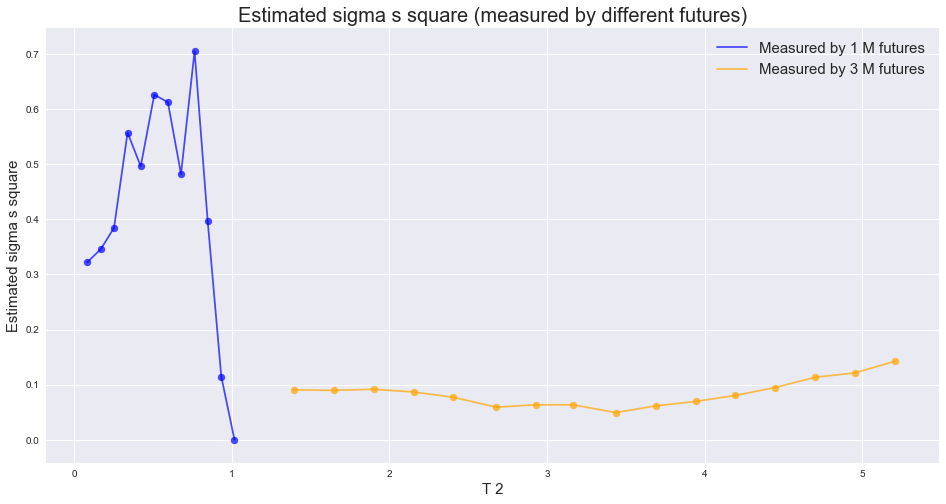

In [15]:
T1_T2_sigma_r_square_1m = T1_T2_sigma_r_square[
    T1_T2_sigma_r_square['Type of futures'] == 1
]

T1_T2_sigma_r_square_3m = T1_T2_sigma_r_square[
    T1_T2_sigma_r_square['Type of futures'] == 3
]

plt.figure(figsize=(16, 8), facecolor='white')

plt.plot(
    T1_T2_sigma_r_square_1m['T2'],
    T1_T2_sigma_r_square_1m['estimated_sigma_s_square'],
    color='blue', alpha=0.7,
    label='Measured by 1 M futures'
)

plt.scatter(
    T1_T2_sigma_r_square_1m['T2'],
    T1_T2_sigma_r_square_1m['estimated_sigma_s_square'],
    color='blue', alpha=0.7,
)

plt.plot(
    T1_T2_sigma_r_square_3m['T2'],
    T1_T2_sigma_r_square_3m['estimated_sigma_s_square'],
    color='orange', alpha=0.7,
    label='Measured by 3 M futures'
)

plt.scatter(
    T1_T2_sigma_r_square_3m['T2'],
    T1_T2_sigma_r_square_3m['estimated_sigma_s_square'],
    color='orange', alpha=0.7,
)

plt.xlabel('T 2', fontsize=15)
plt.ylabel('Estimated sigma s square', fontsize=15)

plt.legend(fontsize=15)
plt.title('Estimated sigma s square (measured by different futures)', fontsize=20);

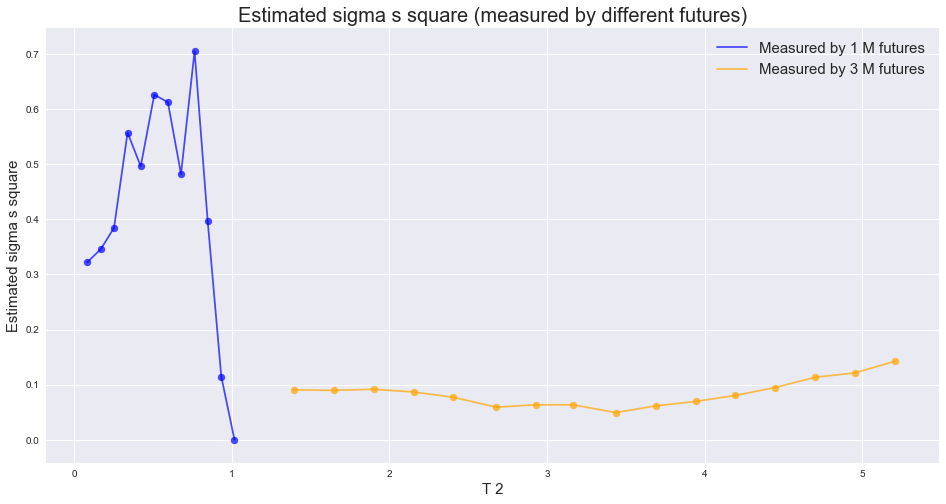

In [15]:
T1_T2_sigma_r_square_1m = T1_T2_sigma_r_square[
    T1_T2_sigma_r_square['Type of futures'] == 1
]

T1_T2_sigma_r_square_3m = T1_T2_sigma_r_square[
    T1_T2_sigma_r_square['Type of futures'] == 3
]

plt.figure(figsize=(16, 8), facecolor='white')

plt.plot(
    T1_T2_sigma_r_square_1m['T2'],
    T1_T2_sigma_r_square_1m['estimated_sigma_s_square'],
    color='blue', alpha=0.7,
    label='Measured by 1 M futures'
)

plt.scatter(
    T1_T2_sigma_r_square_1m['T2'],
    T1_T2_sigma_r_square_1m['estimated_sigma_s_square'],
    color='blue', alpha=0.7,
)

plt.plot(
    T1_T2_sigma_r_square_3m['T2'],
    T1_T2_sigma_r_square_3m['estimated_sigma_s_square'],
    color='orange', alpha=0.7,
    label='Measured by 3 M futures'
)

plt.scatter(
    T1_T2_sigma_r_square_3m['T2'],
    T1_T2_sigma_r_square_3m['estimated_sigma_s_square'],
    color='orange', alpha=0.7,
)

plt.xlabel('T 2', fontsize=15)
plt.ylabel('Estimated sigma s square', fontsize=15)

plt.legend(fontsize=15)
plt.title('Estimated sigma s square (measured by different futures)', fontsize=20);

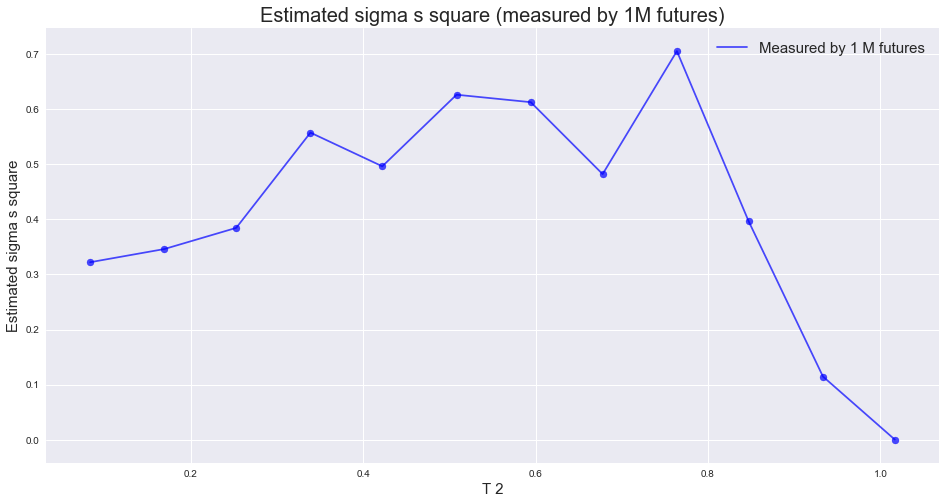

In [16]:
T1_T2_sigma_r_square_1m = T1_T2_sigma_r_square[
    T1_T2_sigma_r_square['Type of futures'] == 1
]

plt.figure(figsize=(16, 8), facecolor='white')

plt.plot(
    T1_T2_sigma_r_square_1m['T2'],
    T1_T2_sigma_r_square_1m['estimated_sigma_s_square'],
    color='blue', alpha=0.7,
    label='Measured by 1 M futures'
)

plt.scatter(
    T1_T2_sigma_r_square_1m['T2'],
    T1_T2_sigma_r_square_1m['estimated_sigma_s_square'],
    color='blue', alpha=0.7,
)

plt.xlabel('T 2', fontsize=15)
plt.ylabel('Estimated sigma s square', fontsize=15)

plt.legend(fontsize=15)
plt.title('Estimated sigma s square (measured by 1M futures)', fontsize=20);

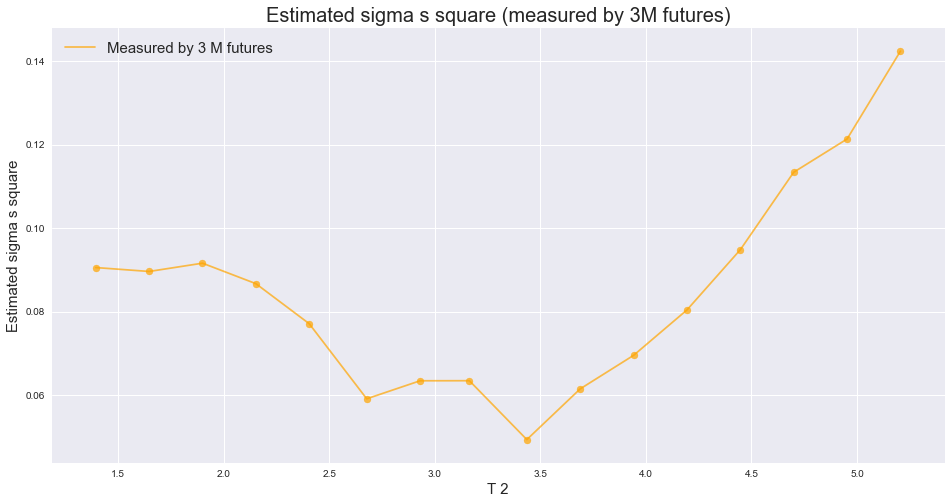

In [17]:
T1_T2_sigma_r_square_3m = T1_T2_sigma_r_square[
    T1_T2_sigma_r_square['Type of futures'] == 3
]

plt.figure(figsize=(16, 8), facecolor='white')

plt.plot(
    T1_T2_sigma_r_square_3m['T2'],
    T1_T2_sigma_r_square_3m['estimated_sigma_s_square'],
    color='orange', alpha=0.7,
    label='Measured by 3 M futures'
)

plt.scatter(
    T1_T2_sigma_r_square_3m['T2'],
    T1_T2_sigma_r_square_3m['estimated_sigma_s_square'],
    color='orange', alpha=0.7,
)

plt.xlabel('T 2', fontsize=15)
plt.ylabel('Estimated sigma s square', fontsize=15)

plt.legend(fontsize=15)
plt.title('Estimated sigma s square (measured by 3M futures)', fontsize=20);

# 隨機入帶值看MSE是否能更好

In [18]:
i = 5

T_1 = T1_T2_sigma_r_square.iloc[i, ]['T1']
T_2 = T1_T2_sigma_r_square.iloc[i, ]['T2']
sigma_r_square_for_match = T1_T2_sigma_r_square.iloc[i, ]['sigma_r_square_for_match']
sigma_r_square = sigma_r_square_series_for_match[sigma_r_square_for_match]
phi_T = T1_T2_sigma_r_square.iloc[i, ]['phi(T1, T2)']
estimated_sigma_s_square = T1_T2_sigma_r_square.iloc[i, ]['estimated_sigma_s_square']

SOFR_futures_rate = T1_T2_sigma_r_square.iloc[i, ]['SOFR futures rate']
current_target = 1 / (1 + SOFR_futures_rate * (T_2 - T_1))

print('estimated_sigma_s_square: {}'.format(estimated_sigma_s_square))
print('target: {}'.format(current_target))
fitted_result = target_function((T_1, T_2, sigma_r_square, phi_T), estimated_sigma_s_square)
print('fitted result: {}'.format(fitted_result))
print('MSE: {}'.format((fitted_result - current_target) ** 2))

estimated_sigma_s_square: 0.6263736432563477
target: 0.9988001912702366
T_1: 0.4222222222222222
T_2: 0.5083333333333333
sigma_r_square: 0.00503540491614152
phi_T: 0.0012646991214141435

fitted result: 0.9988001912702364
MSE: 1.232595164407831e-32


In [19]:
arbitrary_sigma_s_square = 0.6
fitted_result = target_function((T_1, T_2, sigma_r_square, phi_T), arbitrary_sigma_s_square)

print('fitted result: {}'.format(fitted_result))
print('MSE: {}'.format((fitted_result - current_target) ** 2))

T_1: 0.4222222222222222
T_2: 0.5083333333333333
sigma_r_square: 0.00503540491614152
phi_T: 0.0012646991214141435

fitted result: 0.9987974443450606
MSE: 7.545597922483791e-12


基本上fit出來結果MSE已經是0了，任意更改值後MSE無法更小只會變大，代表fit很好。

# 把結果存成CSV

In [20]:
# 只保留要的欄位
result = T1_T2_sigma_r_square[['T2', 'estimated_sigma_s_square']]

# 重新命名column
result = result.rename(columns={'T2': 'Required Tenor'})

# 存結果
result.to_csv('Sigma s square.csv', index=False)